In [ ]:
##################################################
# CVsim.m - Cyclic voltammetry simulation
# Peter Attia
# Based on Bard and Faulkner, Appendix B
# EC mechanism
# Updated September 20, 2020
##################################################

import matplotlib.pyplot as plt
import glob
import numpy as np
import os
import random
from IPython.display import clear_output


#scan variables
D        = .726E-5;   # [=] cm^2/s, O & R diffusion coefficient. Default = 1E-5
etai     = +0.5;   # [=] V, initial overpotential (relative to redox potential). Default = +0.2
etaf     = -0.5;   # [=] V, final overpotential (relative to redox potential). Default = -0.2
offsetV  = 0.1     # [=] V, offset potential for the second electrode. Default = 0.1
v        = .05;   # [=] V/s, sweep rate. Default = 1E-3
C_inital = 1e-3;    # [=] mol/L, initial concentration of O. Default = 1.0
TempK    = 298.15; # [=] K, temperature. Default = 298.15

## Fitting VARIABLES ##
n      = 1.0;                 # [=] number of electrons transfered. Default = 1
alpha  = 0.51;                # [=] dimensionless charge-transfer coefficient. Default = 0.5
k0     = np.power(10,-1.3);   # [=] cm/s, electrochemical rate constant. Default = 1E-2
kc     = 1E-3;                # [=] 1/s, chemical rate constant. Default = 1E-3
area   =  .5*1                #cm^2     
OCP    = 0                    #v

## PHYSICAL CONSTANTS ##
Faraday = 96485;   # [=] C/mol, Faraday's constant
R_ideal = 8.3145;  # [=] J/mol-K, ideal gas constant
f       = Faraday/(R_ideal*TempK); # [=] 1/V, normalized Faraday's constant at room temperature

## SIMULATION VARIABLES ##
L      = 500;    # [=] number of iterations per t_k (pg 790). Default = 500
DM     = 0.45;   # [=] model diffusion coefficient (pg 788). Default = 0.45

etai   -= OCP;   # [=] V, initial overpotential (relative to redox potential). Default = +0.2
etaf   -= OCP;  # [=] V, final overpotential (relative to redox potential). Default = -0.2


def SimulateCurve(gap,area,OCP):
    ## DERIVED CONSTANTS ##
    C = C_inital / 1000           # Convert C from mol/L to mol/cm3
    tk  = 2*(etai-etaf)/v;        # [=] s, characteristic exp. time (pg 790). In this case, total time of fwd and rev scans
    Dt  = tk/L;                  # [=] s, delta time (Eqn B.1.10, pg 790)
    Dx  = np.sqrt(D*Dt/DM);      # [=] cm, delta x (Eqn B.1.13, pg 791)
    nBoxs   = int(np.ceil(4.2*L**0.5)+5);  # number of boxes (pg 792-793). If L~200, j=65

    ## REVERSIBILITY PARAMETERS ##
    ktk    = kc*tk              # dimensionless kinetic parameter (Eqn B.3.7, pg 797)
    km     = ktk/L              # normalized dimensionless kinetic parameter (see bottom of pg 797)
    Lambda = k0/(D*f*v)**0.5     # dimensionless reversibility parameter (Eqn 6.4.4, pg. 236-239)

    k = np.linspace( 0,L,L)                # time index vector
    t = Dt * k             # time vector
    eta1 = etai - v*t      # overpotential vector, negative scan
    eta2 = etaf + v*t      # overpotential vector, positive scan
    eta = np.concatenate([eta1[eta1>etaf] ,eta2[eta2<=etai],eta1[eta1>etaf] ,eta2[eta2<=etai]]) # overpotential scan, both directions
    Enorm = eta*f          # normalized overpotential
    kf = k0*np.exp(  -alpha *n*Enorm)*gap # [=] cm/s, fwd rate constant (pg 799)
    kb = k0*np.exp((1-alpha)*n*Enorm) *gap# [=] cm/s, rev rate constant (pg 799)

 

    eta2= eta + offsetV # overpotential vector, positive scan with offset for second electrode
    Enorm2 = eta2*f        # normalized overpotential for second electrode  
    kf2 = k0*np.exp(  -alpha *n*Enorm2)*gap # [=] cm/s, fwd rate constant for second electrode (pg 799)
    kb2 = k0*np.exp((1-alpha)*n*Enorm2) *gap# [=] cm/s, rev rate constant for second electrode (pg 799)
    

    O = C*np.ones((2*L,nBoxs)) # [=] mol/cm^3, concentration of O
    R = np.zeros((2*L,nBoxs) ) # [=] mol/cm^3, concentration of R
    JO = np.zeros((2*L)) # [=] mol/cm^2-s, flux of O at the surface
    JO2 = np.zeros((2*L)) # [=] mol/cm^2-s, flux of O at the surface for second electrode

    
    times = np.linspace(0,2*L*Dt,len(JO)) # [=] s, time vector for plotting
    for i_time in range(0,2*L-1):
        # Update bulk concentrations of O and R
        for i_dist in range( 1,nBoxs-1):
            O[i_time+1,i_dist] = O[i_time,i_dist] + DM*(O[i_time,i_dist+1]+O[i_time,i_dist-1]-2*O[i_time,i_dist])
            R[i_time+1,i_dist] = R[i_time,i_dist] + DM*(R[i_time,i_dist+1]+R[i_time,i_dist-1]-2*R[i_time,i_dist]) - km * R[i_time,i_dist]

        
        # Update surface concentrations for electrode 1
        JO[i_time+1]   = ( kf[i_time+1]*O[i_time+1,1] - kb[i_time+1]*R[i_time+1,1] ) / (1 + Dx/D*(kf[i_time+1] + kb[i_time+1]) )
         # Update flux for electrode 2 at top of the box
        JO2[i_time+1] = ( kf2[i_time+1]*O[i_time+1,-2] - kb2[i_time+1]*R[i_time+1,-2] ) / (1 + Dx/D*(kf2[i_time+1] + kb2[i_time+1]) )
        
        O[i_time+1,0] = O[i_time+1,1] - JO[i_time+1]*Dx/D
        O[i_time+1,-1] = O[i_time+1,-2] - JO2[i_time+1]*Dx/D
        
        R[i_time+1,0] = R[i_time+1,1] + JO[i_time+1]*Dx/D - km*R[i_time+1,0]
        R[i_time+1,-1] = R[i_time+1,-2] + JO2[i_time+1]*Dx/D - km*R[i_time+1,-1]
        
        #print(JO[i_time+1],JO2[i_time+1], O[i_time+1,0],O[i_time+1,-1]) 
        
    plt.imshow(O, aspect='auto', extent=[0, nBoxs*Dx*1e4, 0, 2*L*Dt], cmap='hot')
    plt.colorbar(label='Concentration of O (mol/cm^3)')
    plt.xlabel('Distance from electrode 1 (um)')
    plt.ylabel('Time (s)')
    plt.show()
    # Calculate current density, Z, from flux of O for electrode 1 
    Z = -n*Faraday*JO * 1000; # [=] A/cm^2 -> mA/cm^2, current density
    # Calculate current density, Z2, from flux of O for electrode 2
    Z2 = -n*Faraday*JO2 * 1000; # [=] A/cm^2 -> mA/cm^2, current density for second electrode

    return times,eta+OCP,Z*area,eta2+OCP,Z2*area

times,eta,Z,eta2,Z2=SimulateCurve(1,area,0)

maxV=eta[ np.argmax(Z)]
minV=eta[ np.argmin(Z)]
print((maxV-minV)*1000,"mV")

fig=plt.figure(figsize=(5,5))
plt.plot(times, Z/area*20,'k.',label='Clean Surface' )
plt.plot(times, Z2/area*20,'k--',label='Offset Surface')
 
plt.xlabel('Time (s)')
plt.ylabel('Current density (10^4 j/Acm^2)')
plt.legend()
plt.show()

fig=plt.figure(figsize=(5,5))
plt.plot(eta, Z/area*20,'k.',label='Clean Surface' )
plt.plot(eta2, Z2/area*20,'k--',label='Offset Surface')
 
plt.xlabel('Overpotential (V)')
plt.ylabel('Current density (10^4 j/Acm^2)')
plt.legend()
plt.show()
 

Electrode gap: 15000 nm (15.0 µm)
Number of boxes: 20
Dx: 0.833333 µm
Dt: 4.304408e-04 s
Steps per segment: 46,465
Total time steps: 185,860
Total simulation time: 80.00 s
Data decimation factor: 37
Output data points: 5,024
Exchange rate per cycle: 0.1000
Exchange coefficient per time step: 4.3043e-06
Average time for wave to travel gap: 3.10e-05 s


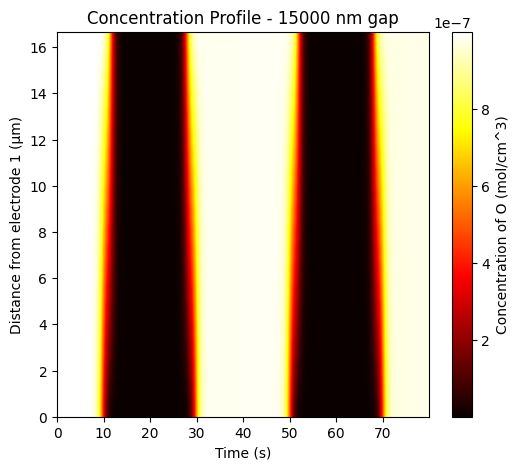

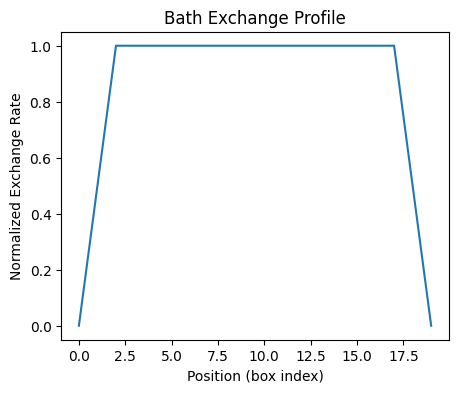

Peak separation: 548.49 mV
Peak current: -0.0000 mA/cm²


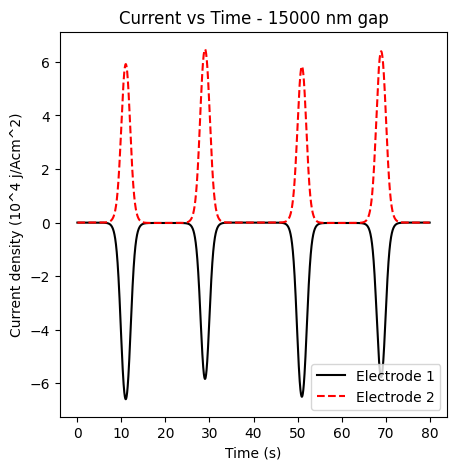

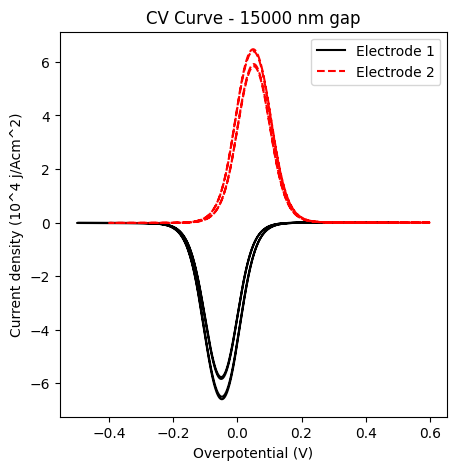

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import deque

# Scan variables
D        = .726E-5    # [=] cm^2/s, O & R diffusion coefficient
etai     = +0.5       # [=] V, initial overpotential (relative to redox potential)
etaf     = -0.5       # [=] V, final overpotential (relative to redox potential)
offsetV  = 0.1        # [=] V, offset potential for the second electrode
v        = .05        # [=] V/s, sweep rate
C_inital = 1e-3       # [=] mol/L, initial concentration of O
TempK    = 298.15     # [=] K, temperature

# Fitting variables
n      = 1.0          # [=] number of electrons transferred
alpha  = 0.51         # [=] dimensionless charge-transfer coefficient
k0     = np.power(10,-1.3)  # [=] cm/s, electrochemical rate constant
kc     = 1E-3         # [=] 1/s, chemical rate constant
area   = .5*1         # cm^2     
OCP    = 0            # V

# Physical constants
Faraday = 96485       # [=] C/mol, Faraday's constant
R_ideal = 8.3145      # [=] J/mol-K, ideal gas constant
f       = Faraday/(R_ideal*TempK)  # [=] 1/V, normalized Faraday's constant at room temperature

# Simulation variables
DM      = 0.45        # [=] model diffusion coefficient

# Adjust initial/final potentials
etai   -= OCP
etaf   -= OCP


def SimulateCurve(electrode_gap_nm, area, OCP, exchange_rate, num_boxes=None, resultingPoints=5000, buffer_size=1000):
    """
    Cyclic voltammetry simulation with bath exchange along the device
    
    Parameters:
    -----------
    electrode_gap_nm : float
        Distance between the two electrodes in nanometers
    area : float
        Electrode area in cm²
    OCP : float
        Open circuit potential in V
    exchange_rate : float
        Rate of exchange with the bath (0-1, where 1 means complete exchange per cycle)
    num_boxes : int, optional
        Number of spatial boxes. If None, will be calculated automatically
    resultingPoints : int, optional
        number of points in the output arrays
    buffer_size : int, optional
        Size of the rolling buffer for concentration visualization
    
    Returns:
    --------
    times, eta, Z, eta2, Z2 : Arrays for time, potentials, and currents
    """
    # Convert electrode gap from nm to cm
    electrode_gap_cm = electrode_gap_nm * 1e-7  # nm to cm conversion
    
    # Derived constants
    C = C_inital / 1000  # Convert C from mol/L to mol/cm3
    
    # We now fix the Dx based on the electrode gap and desired number of boxes
    if num_boxes is None:
        # Calculate a reasonable number of boxes
        num_boxes = max(20, int(50 * 10 / electrode_gap_nm))
    
    # Spatial discretization
    Dx = electrode_gap_cm / (num_boxes - 2)  # Subtract 2 for the electrode positions
    
    # Calculate time step from the Dx (reverse of the original calculation)
    Dt = (Dx**2) * DM / D
    
    # Calculate total time for one scan segment
    seg_time = (etai - etaf) / v  # Time for one scan segment
    
    # Calculate number of time steps needed for full scan (4 segments)
    # We want to make sure we can do a complete cycle
    L_seg = int(np.ceil(seg_time / Dt))  # Steps per segment
    total_steps = 4 * L_seg  # Total steps for 4 segments
    
    # Calculate normalized rate constant for chemical reaction
    km = kc * Dt
    
    # Initialize concentration arrays (only 2 time points needed)
    O_curr = C * np.ones(num_boxes)  # Current time step O concentration
    O_next = np.zeros(num_boxes)     # Next time step O concentration
    R_curr = np.zeros(num_boxes)     # Current time step R concentration
    R_next = np.zeros(num_boxes)     # Next time step R concentration
    
    # Use deques to store subset of data for visualization and buffering
    # These will automatically discard old values when they grow too large
    time_buffer = deque(maxlen=buffer_size)
    O_buffer = deque(maxlen=buffer_size)
    
    data_decimation = max(1, total_steps // resultingPoints)  # Decimation factor for output data
    
    # Initialize output arrays with decimation to save memory
    output_size = total_steps // data_decimation + 1
    times_out = np.zeros(output_size)
    eta_out = np.zeros(output_size)
    eta2_out = np.zeros(output_size)
    Z_out = np.zeros(output_size)
    Z2_out = np.zeros(output_size)
    
  
    exchange_coeff = exchange_rate / total_steps * 8  # Normalized per time step
    
    # Apply exchange differently near electrodes vs. middle to model the spatial distribution
    # Create an exchange profile - more exchange in the center, less near electrodes
    # This simulates a device where the edges (electrodes) are sealed and the middle is open to the bath
    exchange_profile = np.ones(num_boxes)
    electrode_region = int(num_boxes * 0.1)  # 10% of the device near each electrode
    
    # Apply a tapered exchange profile - zero at electrodes, maximum in the middle
    for i in range(electrode_region):
        # Gradual increase from electrode (zero exchange) to inner region
        factor = i / electrode_region
        exchange_profile[i] = factor
        exchange_profile[-(i+1)] = factor
    
    # Scale the profile by the overall exchange coefficient
    exchange_profile *= exchange_coeff
    
    # Print simulation parameters
    print(f"Electrode gap: {electrode_gap_nm} nm ({electrode_gap_cm*1e4} µm)")
    print(f"Number of boxes: {num_boxes}")
    print(f"Dx: {Dx*1e4:.6f} µm")
    print(f"Dt: {Dt:.6e} s")
    print(f"Steps per segment: {L_seg:,}")
    print(f"Total time steps: {total_steps:,}")
    print(f"Total simulation time: {total_steps*Dt:.2f} s")
    print(f"Data decimation factor: {data_decimation}")
    print(f"Output data points: {output_size:,}")
    print(f"Exchange rate per cycle: {exchange_rate:.4f}")
    print(f"Exchange coefficient per time step: {exchange_coeff:.4e}")
    
    print(f'Average time for wave to travel gap: {electrode_gap_cm**2/(D*1e4):.2e} s')
    print(f'Wave Velocity: {electrode_gap_cm/(D*1e4):.2e} cm/s')
    
    # Main simulation loop
    out_idx = 0
    for i_time in range(total_steps):
        # Calculate current time and potential on-the-fly
        t = i_time * Dt
        segment = i_time // L_seg  # Which segment are we in (0-3)
        t_in_segment = (i_time % L_seg) * Dt  # Time within current segment
        
        # Calculate potential based on segment
        if segment == 0 or segment == 2:  # Forward scans
            eta_t = etai - v * t_in_segment
        else:  # Backward scans
            eta_t = etaf + v * t_in_segment
        
        # Calculate potential for second electrode
        eta2_t = eta_t + offsetV
        
        # Calculate overpotentials and rate constants on-the-fly
        Enorm_t = eta_t * f
        Enorm2_t = eta2_t * f
        
        kf_t = k0 * np.exp(-alpha * n * Enorm_t)
        kb_t = k0 * np.exp((1-alpha) * n * Enorm_t)
        
        kf2_t = k0 * np.exp(-alpha * n * Enorm2_t)
        kb2_t = k0 * np.exp((1-alpha) * n * Enorm2_t)
        
        # Update bulk concentrations of O and R
        for i_dist in range(1, num_boxes-1):
            O_next[i_dist] = O_curr[i_dist] + DM*(O_curr[i_dist+1] + O_curr[i_dist-1] - 2*O_curr[i_dist])
            R_next[i_dist] = R_curr[i_dist] + DM*(R_curr[i_dist+1] + R_curr[i_dist-1] - 2*R_curr[i_dist]) - km * R_curr[i_dist]
            
            # Apply bath exchange across the device - this is the key improvement
            # The exchange is spatially distributed according to exchange_profile
            bath_exchange = exchange_profile[i_dist]
            
            # R diffuses out to the bath (where R = 0)
            R_loss = bath_exchange * R_next[i_dist]
            R_next[i_dist] -= R_loss
            
            # O diffuses in from the bath (where O = C)
            O_gain = bath_exchange * (C - O_next[i_dist])
            O_next[i_dist] += O_gain
            
            # Ensure concentrations remain physical
            if O_next[i_dist] > C:
                O_next[i_dist] = C
            if R_next[i_dist] < 0:
                R_next[i_dist] = 0
        
        # Calculate flux at electrode 1
        JO_t = (kf_t * O_next[1] - kb_t * R_next[1]) / (1 + Dx/D * (kf_t + kb_t))
        
        # Calculate flux at electrode 2
        JO2_t = (kf2_t * O_next[-2] - kb2_t * R_next[-2]) / (1 + Dx/D * (kf2_t + kb2_t))
        
        # Update boundary conditions
        O_next[0] = O_next[1] - JO_t * Dx / D
        O_next[-1] = O_next[-2] - JO2_t * Dx / D
        
        R_next[0] = R_next[1] + JO_t * Dx / D - km * R_next[0]
        R_next[-1] = R_next[-2] + JO2_t * Dx / D - km * R_next[-1]
        
        # Store data at decimated intervals to save memory
        if i_time % data_decimation == 0 and out_idx < output_size:
            times_out[out_idx] = t
            eta_out[out_idx] = eta_t + OCP
            eta2_out[out_idx] = eta2_t + OCP
            Z_out[out_idx] = -n * Faraday * JO_t * 1000 * area  # Convert to mA
            Z2_out[out_idx] = -n * Faraday * JO2_t * 1000 * area  # Convert to mA
            out_idx += 1
        
        # Save concentration data for visualization (sparse sampling)
        if i_time % (total_steps // buffer_size) == 0:
            time_buffer.append(t)
            O_buffer.append(O_next.copy())  # Need to copy since we reuse the array
        
        # Swap current and next arrays
        O_curr, O_next = O_next, O_curr
        R_curr, R_next = R_next, R_curr
    
    # Convert buffer data to arrays for visualization
    vis_times = np.array(time_buffer)
    vis_O = np.array(O_buffer)
    
    # Plot concentration profile (using buffered data)
    plt.figure(figsize=(6, 5))
    extent = [0, num_boxes*Dx*1e4, 0, vis_times[-1]]
   
    
    # Create a 2D visualization 
    plt.imshow(vis_O.T, aspect='auto', extent=[0, vis_times[-1], 0, num_boxes*Dx*1e4], origin='lower', cmap='hot')
    plt.colorbar(label='Concentration of O (mol/cm^3)')
    plt.xlabel('Time (s)')
    plt.ylabel('Distance from electrode 1 (µm)')
    plt.title(f'Concentration Profile - {electrode_gap_nm} nm gap')
    plt.show()
    
    # Trim arrays to actual size (in case we didn't fill the output arrays)
    if out_idx < output_size:
        times_out = times_out[:out_idx]
        eta_out = eta_out[:out_idx]
        eta2_out = eta2_out[:out_idx]
        Z_out = Z_out[:out_idx]
        Z2_out = Z2_out[:out_idx]
    
    # Optionally, plot the exchange profile to visualize where exchange happens
    plt.figure(figsize=(5, 4))
    plt.plot(np.arange(num_boxes), exchange_profile / exchange_coeff)
    plt.xlabel('Position (box index)')
    plt.ylabel('Normalized Exchange Rate')
    plt.title('Bath Exchange Profile')
    plt.show()
    
    return times_out, eta_out, Z_out, eta2_out, Z2_out

# Example usage
electrode_gap_nm = 15000  # Distance between electrodes in nanometers
 
# Run simulation with 99% exchange rate with bath per cycle
times, eta, Z, eta2, Z2 = SimulateCurve(electrode_gap_nm, area, OCP, exchange_rate=0.1, resultingPoints=5000)

peak_idx = np.argmax(Z)
max_v = eta[peak_idx]
min_v = eta[np.argmin(Z)]
print(f"Peak separation: {(max_v-min_v)*1000:.2f} mV")
print(f"Peak current: {Z[peak_idx]/area:.4f} mA/cm²")

# Plot current vs time
fig = plt.figure(figsize=(5, 5))
plt.plot(times, Z/area*20, 'k-', label='Electrode 1')
plt.plot(times, Z2/area*20, 'r--', label='Electrode 2')
plt.xlabel('Time (s)')
plt.ylabel('Current density (10^4 j/Acm^2)')
plt.title(f'Current vs Time - {electrode_gap_nm} nm gap')
plt.legend()
plt.show()

# Plot current vs potential (CV curve)
fig = plt.figure(figsize=(5, 5))
plt.plot(eta, Z/area*20, 'k-', label='Electrode 1')
plt.plot(eta2, Z2/area*20, 'r--', label='Electrode 2')
plt.xlabel('Overpotential (V)')
plt.ylabel('Current density (10^4 j/Acm^2)')
plt.title(f'CV Curve - {electrode_gap_nm} nm gap')
plt.legend()
plt.show()

 
 